*"MedHos Smart Purchasing"*

🔮 Iniciando Predicción de Demanda con IA (Prophet)...
   📥 Descargando historia de consumo...


17:51:24 - cmdstanpy - INFO - Chain [1] start processing


   ✅ Dataset listo: 181779 movimientos de insumos Clase A.
   🤖 Entrenando modelos para los Top 20 insumos...


17:51:24 - cmdstanpy - INFO - Chain [1] done processing



📈 Ejemplo de Proyección: Barbijo descartable de tres pl


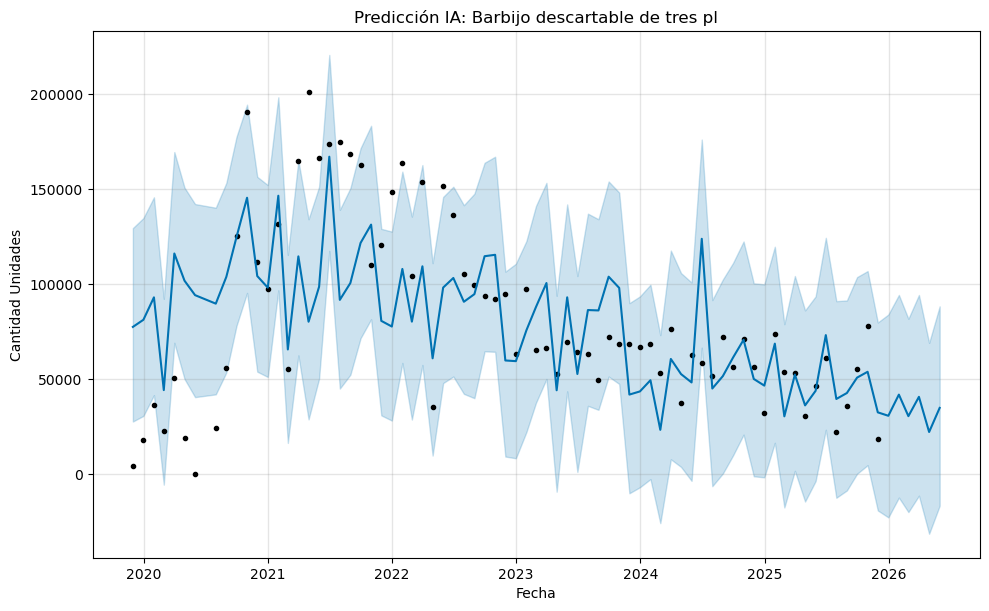

17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:27 - cmdstanpy - INFO - Chain [1] start processing
17:51:27 - cmdstanpy - INFO - Chain [1] done processing
17:51:27 - cmdstanpy - INFO - Chain [1] start processing
17:51:27 - cmdstanpy - INFO - Chain [1] done processing
17:51:27 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:29 - cmdstanpy - INFO - Chain [1] done processing
17:51:29 - cmdstanpy - INFO - Chain [1] start processing
17:51:29 - cmdstanpy - INFO - Chain [1]


💾 Guardando predicciones en 'analytics_predicciones_ia'...
✅ Proceso IA finalizado con éxito.

🔮 --- SUGERENCIA DE COMPRA (Mes +1) ---


,rubro,descripcion_insumo,fecha_prediccion,cantidad_predicha
cod_insumo,,,,
41249,ODONTOLOGIA,Jeringa descartable 10 cc sin,2025-12-31,47870
55316,LABORATORIO,Reactivo p/preanalítica AUTOMA,2025-11-30,40740
25198,ODONTOLOGIA,Solucion cloruro de sodio 0.9%,2025-12-31,38353
50397,ODONTOLOGIA,Camisolin descartable manga la,2025-12-31,32437
57903,ODONTOLOGIA,Barbijo descartable de tres pl,2025-12-31,30684
58489,BIOMEDICOS,Gasa dobladillada 8capas 7x7 p,2025-12-31,29601
50252,BIOMEDICOS,Aguja hipodermica descartable,2025-12-31,26261
50398,ODONTOLOGIA,Camisolin descartable manga la,2025-12-31,25902
50270,ODONTOLOGIA,Pañal descartable c/gel Adulto,2025-12-31,23489


In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import logging

# Silenciar logs de Prophet (para que no llene la pantalla de rojo)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

print("🔮 Iniciando Predicción de Demanda con IA (Prophet)...")

# Conexión
DB_USER = 'analista_medhos'
DB_PASS = 'Medhos2025!'
DB_HOST = 'postgres'
DB_NAME = 'medhos_dw'
engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:5432/{DB_NAME}')

# =============================================================================
# 1. PREPARACIÓN DE DATOS (Solo Salidas = Demanda Real)
# =============================================================================
print("   📥 Descargando historia de consumo...")
# Hacemos JOIN para traer el RUBRO y la CLASE desde la tabla ABC
query = """
SELECT r.cod_insumo, r.descripcion_insumo, r.fecha_movimiento, r.cantidad, a.rubro
FROM raw_movimientos_siga r
JOIN analytics_abc_pareto a ON r.cod_insumo = a.cod_insumo
WHERE r.tipo_archivo_detectado = 'SALIDA'
AND a.clase = 'A' -- Solo predecimos para los críticos
"""
df = pd.read_sql(query, engine)
df['fecha_movimiento'] = pd.to_datetime(df['fecha_movimiento'])

print(f"   ✅ Dataset listo: {len(df)} movimientos de insumos Clase A.")

# =============================================================================
# 2. SELECCIÓN DEL TOP 20 PARA DEMO
# =============================================================================
# Seleccionamos los 20 insumos con mayor volumen histórico para no demorar horas
top_items = df.groupby('cod_insumo')['cantidad'].sum().sort_values(ascending=False).head(20).index.tolist()

print(f"   🤖 Entrenando modelos para los Top {len(top_items)} insumos...")

predicciones_list = []

for codigo in top_items:
    # 1. Filtrar item
    mask = df['cod_insumo'] == codigo
    nombre_item = df[mask]['descripcion_insumo'].iloc[0]
    rubro_item = df[mask]['rubro'].iloc[0]
    
    # 2. Preparar Serie Temporal (Agrupada por MES)
    # CORRECCIÓN: Usamos 'M' (Month End) en lugar de 'ME' por compatibilidad de versión
    serie = df[mask].set_index('fecha_movimiento').resample('M')['cantidad'].sum().reset_index()
    serie.columns = ['ds', 'y']
    
    # Limpieza: Eliminamos meses vacíos si son antiguos
    serie = serie[serie['y'] > 0]
    
    # Necesitamos mínimo 12 puntos de datos (un año) para detectar estacionalidad
    if len(serie) < 12: 
        continue

    # 3. ENTRENAMIENTO PROPHET
    # seasonality_mode='multiplicative': Ideal para demanda que crece con el volumen
    m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(serie)
    
    # 4. PREDICCIÓN (Próximos 6 meses)
    # CORRECCIÓN: Usamos 'M' aquí también
    future = m.make_future_dataframe(periods=6, freq='M') 
    forecast = m.predict(future)
    
    # 5. Guardar Resultados (Solo la parte futura)
    futuro_data = forecast.tail(6)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    futuro_data['cod_insumo'] = codigo
    futuro_data['descripcion_insumo'] = nombre_item
    futuro_data['rubro'] = rubro_item
    
    predicciones_list.append(futuro_data)
    
    # Visualización rápida del PRIMER item para validar
    if codigo == top_items[0]:
        print(f"\n📈 Ejemplo de Proyección: {nombre_item}")
        fig = m.plot(forecast)
        plt.title(f"Predicción IA: {nombre_item}")
        plt.xlabel("Fecha")
        plt.ylabel("Cantidad Unidades")
        plt.show()

# =============================================================================
# 3. CONSOLIDACIÓN Y GUARDADO
# =============================================================================
if predicciones_list:
    df_pred = pd.concat(predicciones_list)
    
    # Renombrar columnas para la BD
    df_pred = df_pred.rename(columns={
        'ds': 'fecha_prediccion',
        'yhat': 'cantidad_predicha',
        'yhat_lower': 'limite_inferior',
        'yhat_upper': 'limite_superior'
    })
    
    # Redondear valores (no existen 0.5 cajas) y evitar negativos
    df_pred['cantidad_predicha'] = df_pred['cantidad_predicha'].apply(lambda x: max(0, round(x)))
    df_pred['limite_inferior'] = df_pred['limite_inferior'].apply(lambda x: max(0, round(x)))
    df_pred['limite_superior'] = df_pred['limite_superior'].apply(lambda x: max(0, round(x)))
    
    print("\n💾 Guardando predicciones en 'analytics_predicciones_ia'...")
    df_pred.to_sql('analytics_predicciones_ia', engine, if_exists='replace', index=False)
    
    with engine.begin() as con:
        con.execute(text("CREATE INDEX IF NOT EXISTS idx_pred_cod ON analytics_predicciones_ia(cod_insumo);"))
        
    print("✅ Proceso IA finalizado con éxito.")
    
    # Mostrar tabla resumen: ¿Qué comprar el próximo mes?
    print("\n🔮 --- SUGERENCIA DE COMPRA (Mes +1) ---")
    # Tomamos la primera fecha de predicción para cada insumo
    prox_mes = df_pred.sort_values('fecha_prediccion').groupby('cod_insumo').first().sort_values('cantidad_predicha', ascending=False)
    
    display(prox_mes[['rubro', 'descripcion_insumo', 'fecha_prediccion', 'cantidad_predicha']].head(10))

else:
    print("⚠️ No se pudieron generar predicciones (datos insuficientes o muy pocos meses de historia).")

In [8]:
import pandas as pd
import numpy as np
from prophet import Prophet
import plotly.graph_objects as go
import plotly.io as pio
from sqlalchemy import create_engine, text
import logging

# Configuración
pd.options.display.float_format = '{:,.2f}'.format
pio.renderers.default = "iframe" 

# Silenciar logs de Prophet
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

print("🔮 Iniciando Predicción de Demanda Segmentada (Prophet + Plotly)...")

# Conexión
DB_USER = 'analista_medhos'
DB_PASS = 'Medhos2025!'
DB_HOST = 'postgres'
DB_NAME = 'medhos_dw'
engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:5432/{DB_NAME}')

# =============================================================================
# 1. PREPARACIÓN DE DATOS
# =============================================================================
print("   📥 Descargando historia de consumo...")
query = """
SELECT r.cod_insumo, r.descripcion_insumo, r.fecha_movimiento, r.cantidad, a.rubro
FROM raw_movimientos_siga r
JOIN analytics_abc_pareto a ON r.cod_insumo = a.cod_insumo
WHERE r.tipo_archivo_detectado = 'SALIDA'
AND a.clase = 'A' 
"""
df = pd.read_sql(query, engine)
df['fecha_movimiento'] = pd.to_datetime(df['fecha_movimiento'])

rubros_analisis = ['MEDICAMENTOS', 'LABORATORIO', 'BIOMEDICOS', 'ODONTOLOGIA']
predicciones_totales = []

# =============================================================================
# 2. PROCESO POR RUBRO
# =============================================================================
for rubro in rubros_analisis:
    print(f"\n🔵 ===================================================")
    print(f"🔬 PROCESANDO RUBRO: {rubro}")
    print(f"🔵 ===================================================")
    
    # Filtro del rubro
    df_rubro = df[df['rubro'] == rubro].copy()
    if len(df_rubro) == 0:
        print("   ⚠️ No hay datos para este rubro.")
        continue

    # Identificar Top 20 por Volumen
    top_items_data = df_rubro.groupby(['cod_insumo', 'descripcion_insumo'])['cantidad'].sum().sort_values(ascending=False).head(20)
    lista_codigos = top_items_data.index.get_level_values('cod_insumo').tolist()
    
    # --- MOSTRAR TABLA TOP 20 ---
    print("📋 TOP 20 PRODUCTOS CRÍTICOS A ANALIZAR:")
    display(top_items_data.to_frame(name="Consumo Histórico Total"))
    
    print(f"   🤖 Entrenando modelos de IA...")

    primero_graficado = False 

    for codigo in lista_codigos:
        mask = df_rubro['cod_insumo'] == codigo
        nombre_item = df_rubro[mask]['descripcion_insumo'].iloc[0]
        
        # Preparar Serie Temporal
        serie = df_rubro[mask].set_index('fecha_movimiento').resample('M')['cantidad'].sum().reset_index()
        serie.columns = ['ds', 'y']
        serie = serie[serie['y'] > 0]
        
        if len(serie) < 12: continue 

        # Entrenar Prophet
        m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(serie)
        
        # Predicción 6 meses
        future = m.make_future_dataframe(periods=6, freq='M')
        forecast = m.predict(future)
        
        # Guardar resultados
        futuro_data = forecast.tail(6)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        futuro_data['cod_insumo'] = codigo
        futuro_data['descripcion_insumo'] = nombre_item
        futuro_data['rubro'] = rubro
        predicciones_totales.append(futuro_data)
        
        # --- MOSTRAR GRÁFICO DEL TOP 1 JUSTO AQUÍ ---
        if not primero_graficado:
            print(f"\n📈 Visualización Modelo: {nombre_item}")
            
            trace_actual = go.Scatter(x=serie['ds'], y=serie['y'], mode='markers', name='Real', marker=dict(color='black', size=6))
            trace_pred = go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Predicción', line=dict(color='#3498db', width=2))
            trace_upper = go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', line=dict(width=0), showlegend=False, hoverinfo='skip')
            trace_lower = go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', line=dict(width=0), fill='tonexty', fillcolor='rgba(52, 152, 219, 0.2)', showlegend=False, hoverinfo='skip')

            fig = go.Figure([trace_upper, trace_lower, trace_actual, trace_pred])
            fig.update_layout(title=f"IA Prophet: {nombre_item} ({rubro})", template="plotly_white", height=400, margin=dict(l=20, r=20, t=40, b=20))
            fig.show()
            
            primero_graficado = True 

# =============================================================================
# 3. CONSOLIDACIÓN Y GUARDADO FINAL
# =============================================================================
if predicciones_totales:
    df_pred = pd.concat(predicciones_totales)
    
    df_pred = df_pred.rename(columns={'ds': 'fecha_prediccion', 'yhat': 'cantidad_predicha', 'yhat_lower': 'limite_inferior', 'yhat_upper': 'limite_superior'})
    cols_num = ['cantidad_predicha', 'limite_inferior', 'limite_superior']
    df_pred[cols_num] = df_pred[cols_num].applymap(lambda x: max(0, round(x)))
    
    print("\n💾 Guardando resultados en tabla 'analytics_predicciones_ia'...")
    df_pred.to_sql('analytics_predicciones_ia', engine, if_exists='replace', index=False)
    
    with engine.begin() as con:
        con.execute(text("CREATE INDEX IF NOT EXISTS idx_pred_rubro ON analytics_predicciones_ia(rubro);"))
        
    print("✅ Guardado Exitoso.")
    
    # Resumen Ejecutivo Final
    print("\n🔮 --- SUGERENCIA DE COMPRA (Próximo Mes) - Resumen Segmentado ---")
    prox_mes = df_pred.sort_values('fecha_prediccion').groupby('cod_insumo').first().reset_index()
    
    for rubro in rubros_analisis:
        subset = prox_mes[prox_mes['rubro'] == rubro].sort_values('cantidad_predicha', ascending=False).head(5)
        if len(subset) > 0:
            print(f"\n📦 {rubro}:")
            display(subset[['descripcion_insumo', 'fecha_prediccion', 'cantidad_predicha']].style.format({'cantidad_predicha': '{:,.0f}'}))
else:
    print("⚠️ No se generaron predicciones.")

🔮 Iniciando Predicción de Demanda Segmentada (Prophet + Plotly)...
   📥 Descargando historia de consumo...

🔵 ===================================================
🔬 PROCESANDO RUBRO: MEDICAMENTOS
🔵 ===================================================
📋 TOP 20 PRODUCTOS CRÍTICOS A ANALIZAR:


,,Consumo Histórico Total
cod_insumo,descripcion_insumo,
25198,Solucion cloruro de sodio 0.9%,"572,337.00"
1241,Leche entera Fortificada con V,"436,061.00"
54777,Solucion de cloruro de sodio 0,"350,306.00"
20913,Midazolan 15 mg ampolla x 3 ml,"285,802.00"
20911,Propofol 10 mg/ml ampolla x 20,"242,534.00"
25200,Solucion de cloruro de sodio 0,"158,232.00"
20811,Atracurio 50 mg/5 ml ampolla,"99,785.00"
25180,Solucion de dextrosa 5% en agu,"98,665.00"
21275,Piperacilin 4 g + tazobactam 0,"97,517.00"


   🤖 Entrenando modelos de IA...

📈 Visualización Modelo: Solucion cloruro de sodio 0.9%



🔵 ===================================================
🔬 PROCESANDO RUBRO: LABORATORIO
🔵 ===================================================
📋 TOP 20 PRODUCTOS CRÍTICOS A ANALIZAR:


,,Consumo Histórico Total
cod_insumo,descripcion_insumo,
39547,Tubo p/ hemograma c/edta 3ml c,"1,044,100.00"
39838,Reactivo p/glucosa AUTOMATIZAD,"727,100.00"
55316,Reactivo p/preanalítica AUTOMA,"696,500.00"
39836,Reactivo p/creatinina AUTOMATI,"696,500.00"
39841,Reactivo p/urea AUTOMATIZADO,"642,500.00"
39831,Reactivo p/GOT AUTOMATIZADO,"531,710.00"
39832,Reactivo p/GPT AUTOMATIZADO,"517,211.00"
39837,Reactivo p/ Fosfatasa alcalina,"495,817.00"
51422,Reactivo p/bilirrubina total A,"490,350.00"


   🤖 Entrenando modelos de IA...

📈 Visualización Modelo: Tubo p/ hemograma c/edta 3ml c



🔵 ===================================================
🔬 PROCESANDO RUBRO: BIOMEDICOS
🔵 ===================================================
📋 TOP 20 PRODUCTOS CRÍTICOS A ANALIZAR:


,,Consumo Histórico Total
cod_insumo,descripcion_insumo,
57903,Barbijo descartable de tres pl,"2,927,133.00"
58489,Gasa dobladillada 8capas 7x7 p,"2,129,295.00"
41249,Jeringa descartable 10 cc sin,"1,954,013.00"
50252,Aguja hipodermica descartable,"1,770,672.00"
50397,Camisolin descartable manga la,"1,182,931.00"
51709,Aposito 10x20 cm 14 gr confec.,"1,058,927.00"
51006,Tubo para suero c/5ml gel y ac,"991,149.00"
41251,Jeringa descartable 5 cc sin a,"782,650.00"
25986,Cofia quirúrgica elastizado de,"762,724.00"


   🤖 Entrenando modelos de IA...

📈 Visualización Modelo: Barbijo descartable de tres pl



🔵 ===================================================
🔬 PROCESANDO RUBRO: ODONTOLOGIA
🔵 ===================================================
📋 TOP 20 PRODUCTOS CRÍTICOS A ANALIZAR:


,,Consumo Histórico Total
cod_insumo,descripcion_insumo,
57903,Barbijo descartable de tres pl,"2,927,133.00"
41066,Vaso plastico descartable x un,"2,436,578.00"
41249,Jeringa descartable 10 cc sin,"1,954,013.00"
50397,Camisolin descartable manga la,"1,182,931.00"
25986,Cofia quirúrgica elastizado de,"762,724.00"
50398,Camisolin descartable manga la,"680,096.00"
50270,Pañal descartable c/gel Adulto,"675,440.00"
25198,Solucion cloruro de sodio 0.9%,"572,337.00"
40212,Guante nitrilo descart. chico,"268,971.00"


   🤖 Entrenando modelos de IA...

📈 Visualización Modelo: Barbijo descartable de tres pl



💾 Guardando resultados en tabla 'analytics_predicciones_ia'...
✅ Guardado Exitoso.

🔮 --- SUGERENCIA DE COMPRA (Próximo Mes) - Resumen Segmentado ---

📦 MEDICAMENTOS:


/tmp/ipykernel_9205/1401731579.py:118: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,descripcion_insumo,fecha_prediccion,cantidad_predicha
17,Solucion de cloruro de sodio 0,2025-12-31 00:00:00,"10,318"
11,Propofol 10 mg/ml ampolla x 20,2025-12-31 00:00:00,"4,375"
15,Solucion de dextrosa 5% en agu,2025-12-31 00:00:00,"4,085"
18,Solucion de ringer lactato x 5,2025-12-31 00:00:00,"1,912"
0,Leche entera Fortificada con V,2024-10-31 00:00:00,"1,610"



📦 LABORATORIO:


,descripcion_insumo,fecha_prediccion,cantidad_predicha
61,Reactivo p/preanalítica AUTOMA,2025-11-30 00:00:00,"40,740"
49,Reactivo p/hemograma AUTOMATIZ,2025-11-30 00:00:00,"25,331"
28,Reactivo p/creatinina AUTOMATI,2025-12-31 00:00:00,"17,636"
30,Reactivo p/glucosa AUTOMATIZAD,2025-12-31 00:00:00,"16,807"
22,Tubo p/ hemograma c/edta 3ml c,2025-12-31 00:00:00,"16,309"



📦 BIOMEDICOS:


,descripcion_insumo,fecha_prediccion,cantidad_predicha
69,Gasa dobladillada 8capas 7x7 p,2025-12-31 00:00:00,"29,601"
44,Aguja hipodermica descartable,2025-12-31 00:00:00,"26,261"
41,Jeringa descartable 10 cc sin,2025-12-31 00:00:00,"23,935"
53,Aposito 10x20 cm 14 gr confec.,2025-12-31 00:00:00,"20,724"
43,Aguja hipodermica descartable,2025-09-30 00:00:00,"17,104"



📦 ODONTOLOGIA:


,descripcion_insumo,fecha_prediccion,cantidad_predicha
16,Solucion cloruro de sodio 0.9%,2025-12-31 00:00:00,"19,176"
35,Guante nitrilo descart. chico,2024-06-30 00:00:00,"16,890"
68,Barbijo descartable de tres pl,2025-12-31 00:00:00,"15,342"
65,Bolsa papel KRAFT medida aprox,2025-12-31 00:00:00,"3,614"
64,Bolsa papel kraft medida aprox,2025-12-31 00:00:00,"2,564"


### Herramienta de Presupuesto Financiero
Al proyectar 3 meses, le estás dando al Directorio la previsión de flujo de caja necesaria para el próximo trimestre.
Aquí tienes el bloque de código para agregar al final del Notebook 04.
¿Qué hace este script?
Toma las predicciones que generamos en el paso anterior.
Filtra los próximos 3 meses cronológicos.
Suma la cantidad total necesaria (Q).
Busca el Precio Unitario Dolarizado (P) (usando el promedio 2025 para mayor precisión).
Calcula el Presupuesto Total Estimado (P x Q).
Genera una tabla separada por cada Rubro.

In [5]:
# =============================================================================
# 5. REPORTE FINANCIERO: PLAN DE COMPRA TRIMESTRAL (3 MESES)
# =============================================================================
print("\n💰 --- PLAN DE COMPRA TRIMESTRAL (Sugerencia IA) ---")
print("ℹ️  Calculado sumando la demanda predicha para los próximos 3 meses.")

# 1. Obtener Precios de Referencia (Dolarizados)
# Usamos la misma lógica blindada del Semáforo: Prioridad 2025 -> Fallback Histórico
print("   💵 Buscando precios de referencia actualizados...")

query_precios_2025 = """
SELECT r.cod_insumo, AVG(r.precio_unitario / c.tipo_cambio_oficial_venta) as precio_usd_2025
FROM raw_movimientos_siga r
JOIN dim_cotizaciones c ON r.fecha_movimiento = c.fecha
WHERE r.tipo_archivo_detectado = 'ENTRADA' 
AND r.precio_unitario > 0
AND r.fecha_movimiento >= '2025-01-01'
GROUP BY r.cod_insumo
"""
df_precios = pd.read_sql(query_precios_2025, engine)

# Recargamos la tabla de predicciones recién generada
df_pred_full = pd.read_sql("SELECT * FROM analytics_predicciones_ia", engine)
df_pred_full['fecha_prediccion'] = pd.to_datetime(df_pred_full['fecha_prediccion'])

# 2. Filtrar Próximos 3 Meses
# Ordenamos por fecha y tomamos las primeras 3 filas de cada insumo
df_3_meses = df_pred_full.sort_values('fecha_prediccion').groupby('cod_insumo').head(3)

# 3. Agrupar (Sumar cantidades)
plan_compra = df_3_meses.groupby(['rubro', 'cod_insumo', 'descripcion_insumo'])['cantidad_predicha'].sum().reset_index()
plan_compra.rename(columns={'cantidad_predicha': 'cantidad_trimestral'}, inplace=True)

# 4. Cruzar con Precios
# Aseguramos tipos de datos string para el cruce
plan_compra['cod_insumo'] = plan_compra['cod_insumo'].astype(str)
df_precios['cod_insumo'] = df_precios['cod_insumo'].astype(str)

plan_final = plan_compra.merge(df_precios, on='cod_insumo', how='left')

# Si no hay precio 2025, usamos 0 (o podríamos buscar histórico, pero mejor ser conservador aquí)
plan_final['precio_usd_2025'] = plan_final['precio_usd_2025'].fillna(0)
plan_final['costo_total_estimado'] = plan_final['cantidad_trimestral'] * plan_final['precio_usd_2025']

# 5. Generar Tablas por Rubro
rubros_orden = ['MEDICAMENTOS', 'LABORATORIO', 'BIOMEDICOS', 'ODONTOLOGIA']

for rubro in rubros_orden:
    subset = plan_final[plan_final['rubro'] == rubro].copy()
    
    if len(subset) == 0: continue
    
    # Ordenar por costo total (Impacto Financiero)
    subset = subset.sort_values('costo_total_estimado', ascending=False)
    
    total_rubro = subset['costo_total_estimado'].sum()
    
    print(f"\n📦 RUBRO: {rubro}")
    print(f"   Presupuesto Estimado (3 Meses): USD {total_rubro:,.2f}")
    
    # Formateo para mostrar
    display(subset[['descripcion_insumo', 'cantidad_trimestral', 'precio_usd_2025', 'costo_total_estimado']]
            .head(20) # Mostramos Top 20 del plan
            .style.format({
                'cantidad_trimestral': '{:,.0f}',
                'precio_usd_2025': '${:,.2f}',
                'costo_total_estimado': '${:,.2f}'
            })
            .background_gradient(subset=['costo_total_estimado'], cmap='Greens')
           )


💰 --- PLAN DE COMPRA TRIMESTRAL (Sugerencia IA) ---
ℹ️  Calculado sumando la demanda predicha para los próximos 3 meses.
   💵 Buscando precios de referencia actualizados...

📦 RUBRO: MEDICAMENTOS
   Presupuesto Estimado (3 Meses): USD 148,841.81


,descripcion_insumo,cantidad_trimestral,precio_usd_2025,costo_total_estimado
49,Propofol 10 mg/ml ampolla x 20,"12,365",$1.99,"$24,583.69"
54,Solucion cloruro de sodio 0.9%,"28,090",$0.85,"$23,842.46"
51,Piperacilin 4 g + tazobactam 0,"3,319",$6.98,"$23,151.36"
44,Ampicilina 1 gr + sulbactam 50,"3,185",$4.07,"$12,952.16"
55,Solucion de cloruro de sodio 0,"13,174",$0.84,"$11,087.92"
53,Solucion de dextrosa 5% en agu,"11,112",$0.93,"$10,336.52"
59,Solucion de cloruro de sodio 0,"11,392",$0.76,"$8,674.69"
52,Heparina sodica 5.000 UI frasc,"1,452",$5.30,"$7,696.35"
43,Omeprazol 40 mg ampolla,"2,599",$2.47,"$6,422.90"
56,Solucion de ringer lactato x 5,"4,989",$1.21,"$6,019.30"



📦 RUBRO: LABORATORIO
   Presupuesto Estimado (3 Meses): USD 1,691,757.03


,descripcion_insumo,cantidad_trimestral,precio_usd_2025,costo_total_estimado
33,Reactivo p/hemograma AUTOMATIZ,"989,945",$1.30,"$1,291,843.82"
39,Reactivo p/preanalítica AUTOMA,"1,007,980",$0.29,"$289,190.15"
22,Reactivo p/hemoglobina glicosi,"10,260",$1.60,"$16,450.06"
21,Reactivo p/TSH AUTOMATIZADO,"15,107",$0.90,"$13,547.66"
32,Reactivo p/colesterol HDL AUTO,"27,167",$0.45,"$12,342.96"
20,Tubo p/ hemograma c/edta 3ml c,"49,106",$0.17,"$8,144.30"
34,Reactivo p/T4 free AUTOMATIZAD,"7,736",$0.97,"$7,493.56"
27,Reactivo p/ Fosfatasa alcalina,"31,456",$0.22,"$6,909.03"
24,Reactivo p/GPT AUTOMATIZADO,"33,434",$0.18,"$5,902.19"
23,Reactivo p/GOT AUTOMATIZADO,"31,936",$0.18,"$5,644.40"



📦 RUBRO: BIOMEDICOS
   Presupuesto Estimado (3 Meses): USD 96,511.36


,descripcion_insumo,cantidad_trimestral,precio_usd_2025,costo_total_estimado
9,Camisolin descartable manga la,"36,208",$0.58,"$20,873.22"
10,Camisolin descartable manga la,"19,082",$0.75,"$14,261.01"
15,Solucion de cloruro de sodio 0,"17,373",$0.76,"$13,229.05"
11,Tubo para suero c/5ml gel y ac,"40,585",$0.27,"$10,991.20"
19,Gasa dobladillada 8capas 7x7 p,"86,232",$0.10,"$8,901.24"
12,Aposito 10x20 cm 14 gr confec.,"44,006",$0.14,"$5,982.02"
14,Apósito de 20x20 cm 25 gr conf,"12,290",$0.42,"$5,101.66"
8,Pañal descartable c/gel Adulto,"19,382",$0.24,"$4,561.88"
16,Tubo para suero c/gel 3.5ml y,"16,037",$0.27,"$4,331.63"
4,Jeringa descartable 10 cc sin,"46,822",$0.05,"$2,496.58"



📦 RUBRO: ODONTOLOGIA
   Presupuesto Estimado (3 Meses): USD 48,455.37


,descripcion_insumo,cantidad_trimestral,precio_usd_2025,costo_total_estimado
61,Solucion cloruro de sodio 0.9%,"19,176",$0.85,"$16,276.36"
72,Camisolin descartable manga la,"12,951",$0.75,"$9,678.98"
71,Camisolin descartable manga la,"16,218",$0.58,"$9,349.37"
60,Guante latex descart.p/examen,"2,766",$2.40,"$6,643.73"
70,Pañal descartable c/gel Adulto,"11,744",$0.24,"$2,764.15"
69,Jeringa descartable 10 cc sin,"23,935",$0.05,"$1,276.23"
78,Barbijo descartable de tres pl,"36,248",$0.02,$701.10
74,Integrador quimico clase V par,"4,017",$0.14,$572.26
75,Bolsa papel kraft medida aprox,"8,288",$0.06,$523.00
79,Prueba rápida Naso/Faringea de,104,$3.17,$330.14
